Age Wizard
---

Download all the Jupyter notebooks from: https://github.com/HeloiseS/hoki/tree/master/tutorials

#  Initial imports

In [1]:
from hoki.age.wizard import AgeWizard
import hoki
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hoki.load import unpickle
import hoki.constants as hc

%matplotlib inline
plt.style.use('tuto.mplstyle')

---
### Update May 2021

Note that the `hoki.age_utils` module has been replaced by the `hoki.age` subpackage. 
The `hoki.age_utils` module is still part of the current hoki releases and will be until hoki v2.0 for backward compatibility but it will **not be updated or maintained**. 

If you import `hoki.age_utils` you will see the following deprecation message:
```
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Deprecated since hoki v1.6 
PLEASE USE THE hoki.age SUBPACKAGE AND MODULES WITHIN. 
e.g. from hoki.age.wizard import AgeWizard
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

```

**You are strongly advised to use the `hoki.age` subpackage as shown in this tutorial.**

---

# A systematic ageing method 

### Motivation
One of the classic methods for ageing clusters is to fit isochrones to observational data in Colour-Magnitude Diagrams (CMDs)  or in Hertzsprung-Russel Diagrams (HRDs).

There are a number of issues with this ubiquitous technique though:

* Fitting is usually done by eye
* They only take into account single stars
* It cannot be used if your sample only contains a few sources

**Our goal is to provide a method that answers all of the issues metioned above**

### How it works

By matching the observed properties of your sources to the BPASS models you can find the **most likely age** of a **location on the HRD/CMD**.


<img src="./images/age_method.png" alt="Drawing" style="width: 1000px;"/>

If all your sources belong to the same region, you can then combine the PDFs of your individual sources to find the age PDF of the whole cluster.

All of this can be done step by step using the chain `find_coordinates()` -> `calculate_pdfs` -> `multiply_pdfs()`, or you could simply use `AgeWizard()` which handles this pipeline and facilitates loading in the models. 

Note: In this tutorial we will focus on `AgeWizard()`.


### Remember to exercise caution in your interpretation

This is true of all methods but it is worth repeating. This technique helps you get to the answer, but it doesn't give you the answer. 

The **most likely age** of the **matching location** is not necessarily the age of your source - as we'll see below Helium Stars created through binary interactions and envelope stripping are found at similar locations as WR stars but at different ages.

# Ages from Hertzsprung-Russell Diagram

First, we need some observational data to compare to our models. 

`AgeWizard()` expects a `pandas.DataFrame`. If you want to use the HRD capabilities you will need to provide a `logT` and a `logL` column:
* logT: log10 of the stellar effective temperature
* logL: log10 of the stellar luminosity **in units of Solar Luminosities**

Additionally, your DataFrame will ideally contain a `name` column  with the name of the sources you're working on. If you don't provide one, `AgeWizard()` will make it's own sources names: source1, source2, etc...

_Data source: McLeod et al. 2019, Stevance et al. in prep._

In [2]:
stars = pd.DataFrame.from_dict({'name':np.array(['Star1','Star2','Star3','Star4', 
                                                 'Star5','Star6','Star7','Star8','Star9',
                                                 'Star10','Star11','Star12','Star13','Star14', 
                                                 'WR1', 'WR2']),
                                'logL':np.array([5.0, 5.1, 4.9, 5.9, 5.0, 5.4, 4.3, 5.7, 4.5, 4.5, 
                                                 4.9, 4.5, 4.3, 4.5, 5.3, 5.3]), 
                                'logT':np.array([4.48, 4.45, 4.46, 4.47, 4.48, 4.53, 4.52, 4.52, 4.52,
                                                 4.56, 4.46, 4.52, 4.52, 4.52, 4.9, 4.65])})

Now we initialise our `AgeWizard()`. Each instance corresponds to one model and one model only: i.e. 1 IMF and 1 metalicity.

If we want to have a look at 2 different metallicities for example, we can just instanciate `AgeWizard` twice:

In [3]:
agewiz006 = AgeWizard(obs_df=stars, model='./data/hrs-bin-imf135_300.z006.dat')
agewiz008 = AgeWizard(obs_df=stars, model='./data/hrs-bin-imf135_300.z008.dat')

[---INFO---] AgeWizard Starting
[--RUNNING-] Initial Checks
Stack has been reset
[-COMPLETE-] Initial Checks
[---INFO---] ERROR_FLAG=None / No errors detected
[---INFO---] Distributions Calculated Successfully
[---INFO---] Distributions Normalised to PDFs Successfully
[---INFO---] AgeWizard Starting
[--RUNNING-] Initial Checks
Stack has been reset
[-COMPLETE-] Initial Checks
[---INFO---] ERROR_FLAG=None / No errors detected
[---INFO---] Distributions Calculated Successfully
[---INFO---] Distributions Normalised to PDFs Successfully


During instanciation, the observations and models are matched and the age PDFs are calculated. They are summarised in a `pandas.DataFrame` that you can access as follows. 

In [4]:
agewiz006.pdfs.head(15)

name,Star1,Star2,Star3,Star4,Star5,Star6,Star7,Star8,Star9,Star10,Star11,Star12,Star13,Star14,WR1,WR2
0,0.000000,0.000000,0.000000,1.298460e-11,0.000000,0.000000,0.025706,5.594794e-11,0.021803,0.000000e+00,0.000000,0.021803,0.025706,0.021803,0.000000e+00,0.107142
1,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.036928,0.000000e+00,0.030149,0.000000e+00,0.000000,0.030149,0.036928,0.030149,0.000000e+00,0.004603
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.046310,0.000000e+00,0.035243,0.000000e+00,0.000000,0.035243,0.046310,0.035243,0.000000e+00,0.006676
3,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.058174,0.000000e+00,0.052005,7.820472e-08,0.000000,0.052005,0.058174,0.052005,0.000000e+00,0.012032
4,0.000000,0.000000,0.000654,0.000000e+00,0.000000,0.000000,0.081692,0.000000e+00,0.057408,1.012331e-04,0.000654,0.057408,0.081692,0.057408,0.000000e+00,0.003365
5,0.000000,0.000000,0.015330,7.629112e-01,0.000000,0.000000,0.063921,4.216232e-03,0.074740,9.941176e-07,0.015330,0.074740,0.063921,0.074740,4.525980e-08,0.009378
6,0.075321,0.011572,0.142812,1.100859e-01,0.075321,0.003387,0.078904,2.914504e-01,0.086366,1.476180e-04,0.142812,0.086366,0.078904,0.086366,0.000000e+00,0.000145
7,0.238335,0.430026,0.233166,8.879082e-02,0.238335,0.558455,0.135883,4.335802e-01,0.093930,1.763084e-03,0.233166,0.093930,0.135883,0.093930,2.155362e-14,0.015148
8,0.295138,0.348300,0.279178,2.892240e-02,0.295138,0.345761,0.187286,1.529185e-01,0.147844,4.403392e-03,0.279178,0.147844,0.187286,0.147844,3.207127e-01,0.023512
9,0.324156,0.153717,0.267386,9.289685e-03,0.324156,0.044554,0.176904,8.005393e-02,0.204892,1.732683e-02,0.267386,0.204892,0.176904,0.204892,5.301331e-01,0.745544


But those are just numbers... PDFs are meant to be plotted:

In [5]:
def plot_all_pdfs(agewiz):
    # creating the figure
    f, ax = plt.subplots(4, 4, figsize=(15,15))
    plt.subplots_adjust(hspace=0.4)
    axes = ax.reshape(16)

    # We plot each star an individual axis 
    for source, axis in zip(agewiz.sources, axes):
        
        # Plotting one PDF
        axis.step(hoki.BPASS_TIME_BINS, agewiz.pdfs[source],where='mid')
        axis.fill_between(hoki.BPASS_TIME_BINS, agewiz.pdfs[source], step='mid', alpha=0.3)
        
        # Labels and limits
        axis.set_title(source)
        axis.set_ylabel('Probability (%)')
        axis.set_xlabel('log(years)')
        axis.set_ylim([0,0.6])    
        axis.set_xlim([6,8.5])     
    

### Age PDFs at z=0.006

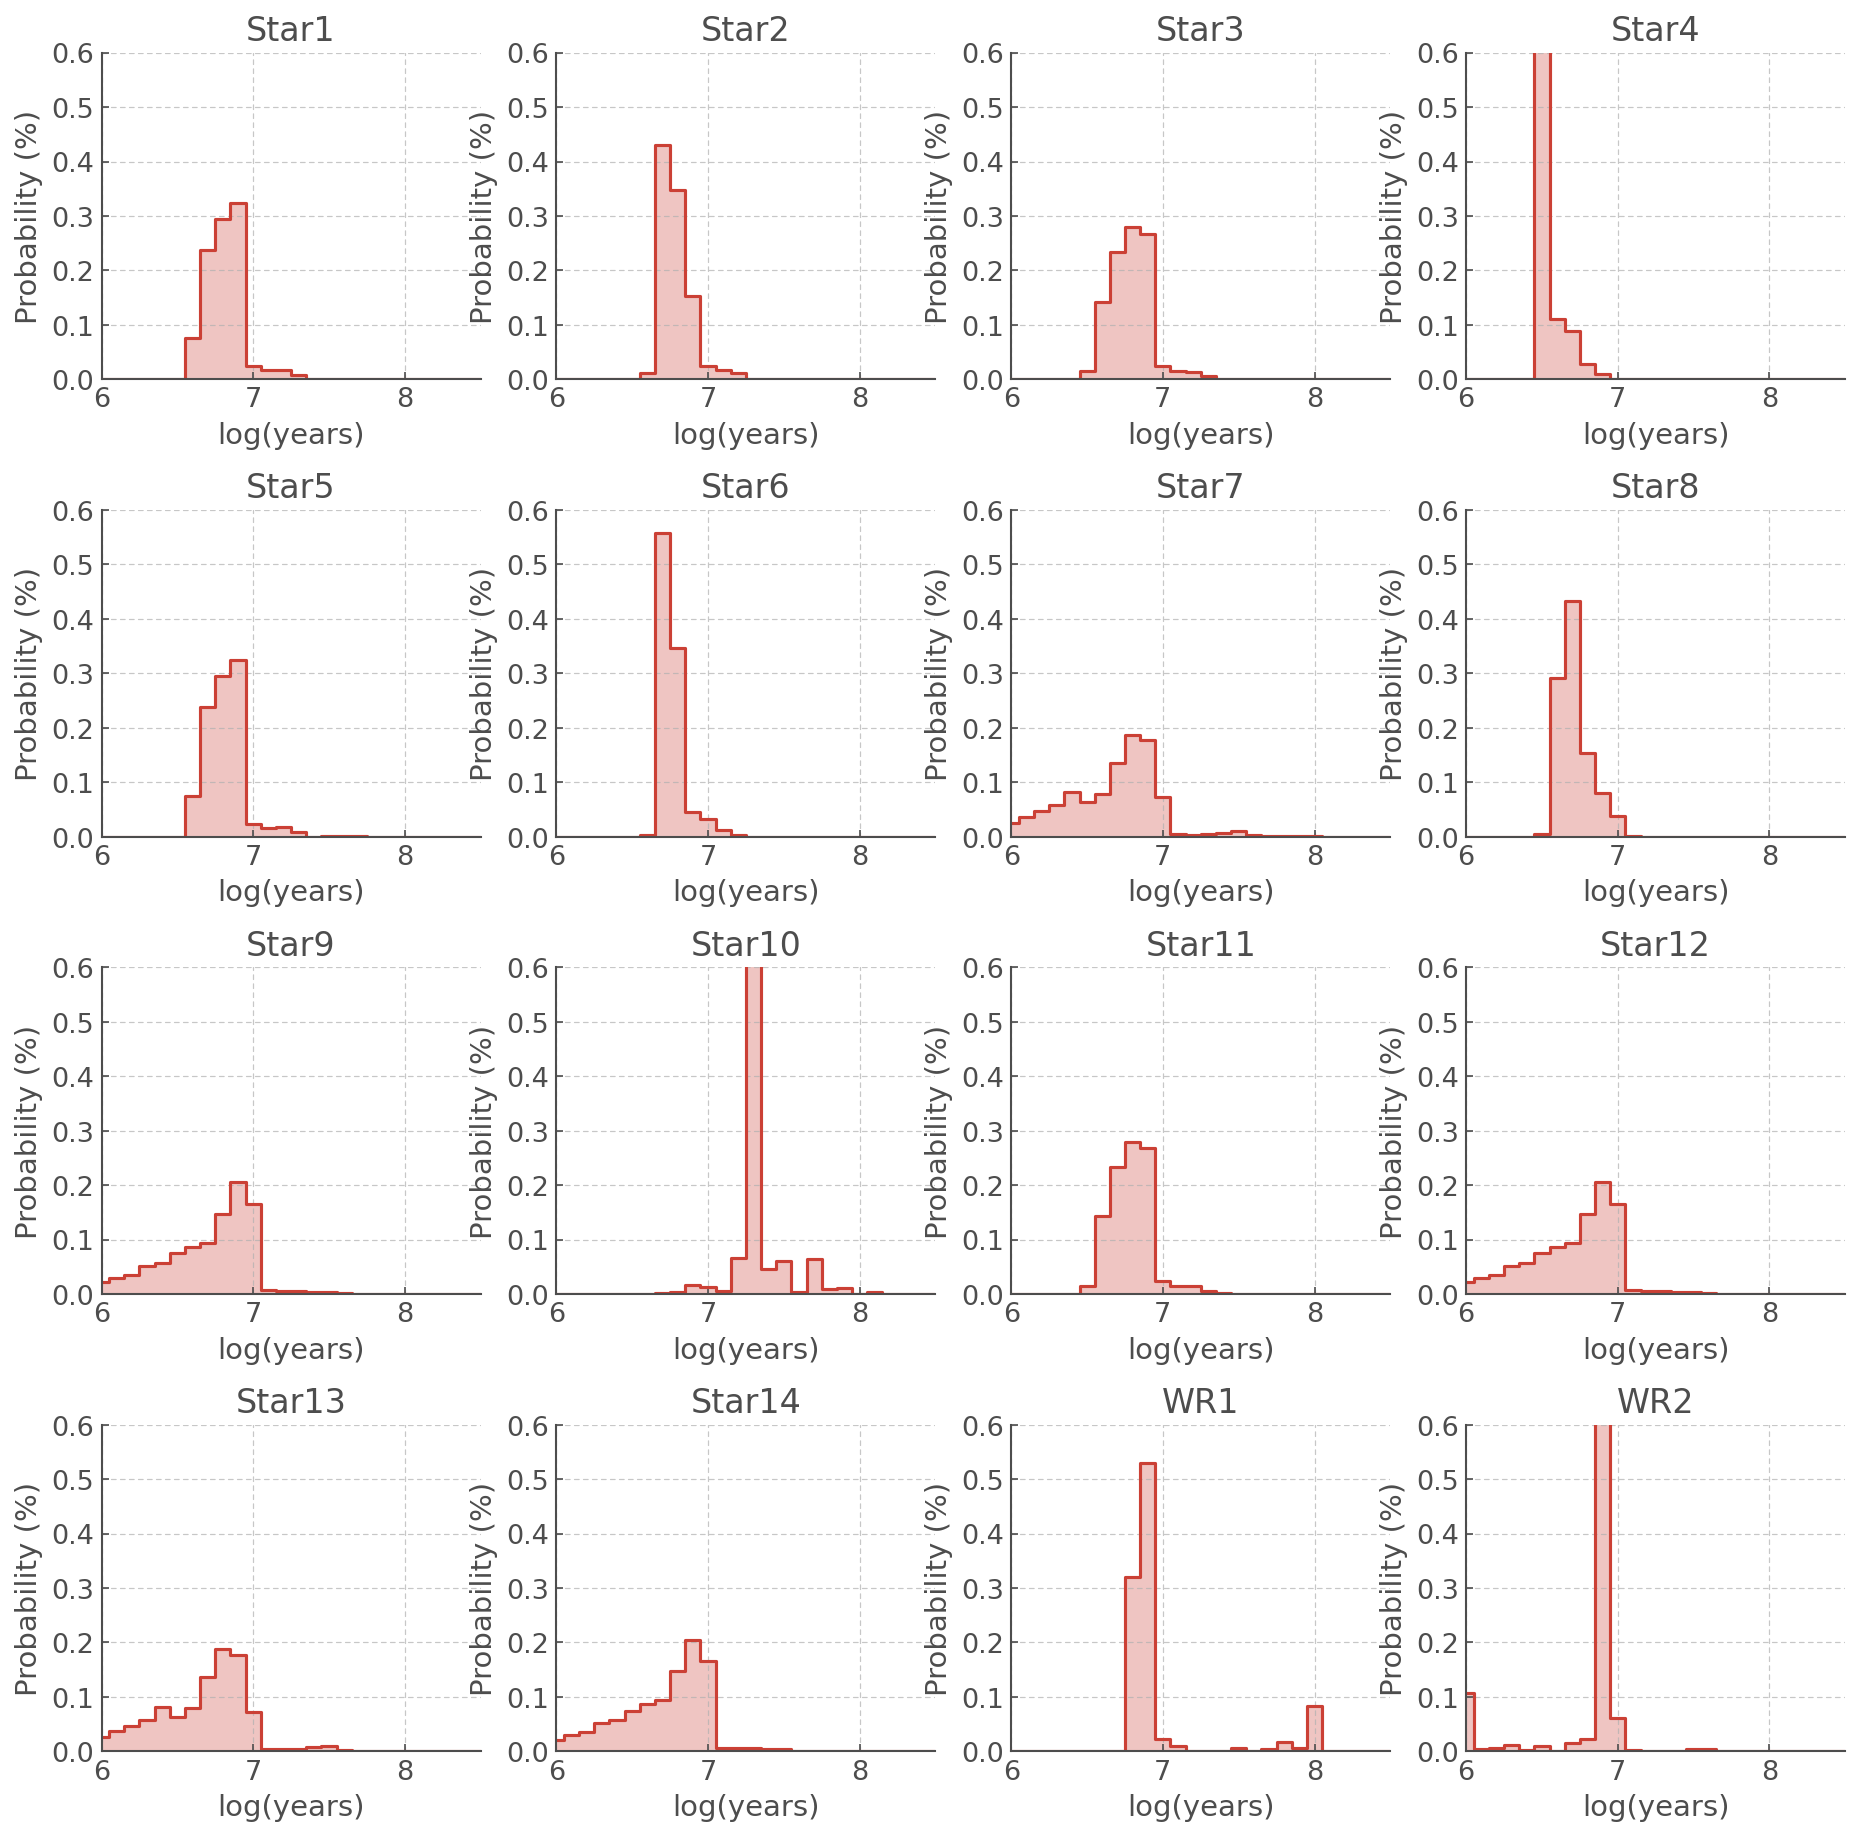

In [6]:
plot_all_pdfs(agewiz006)

### Age PDFs at z=0.008

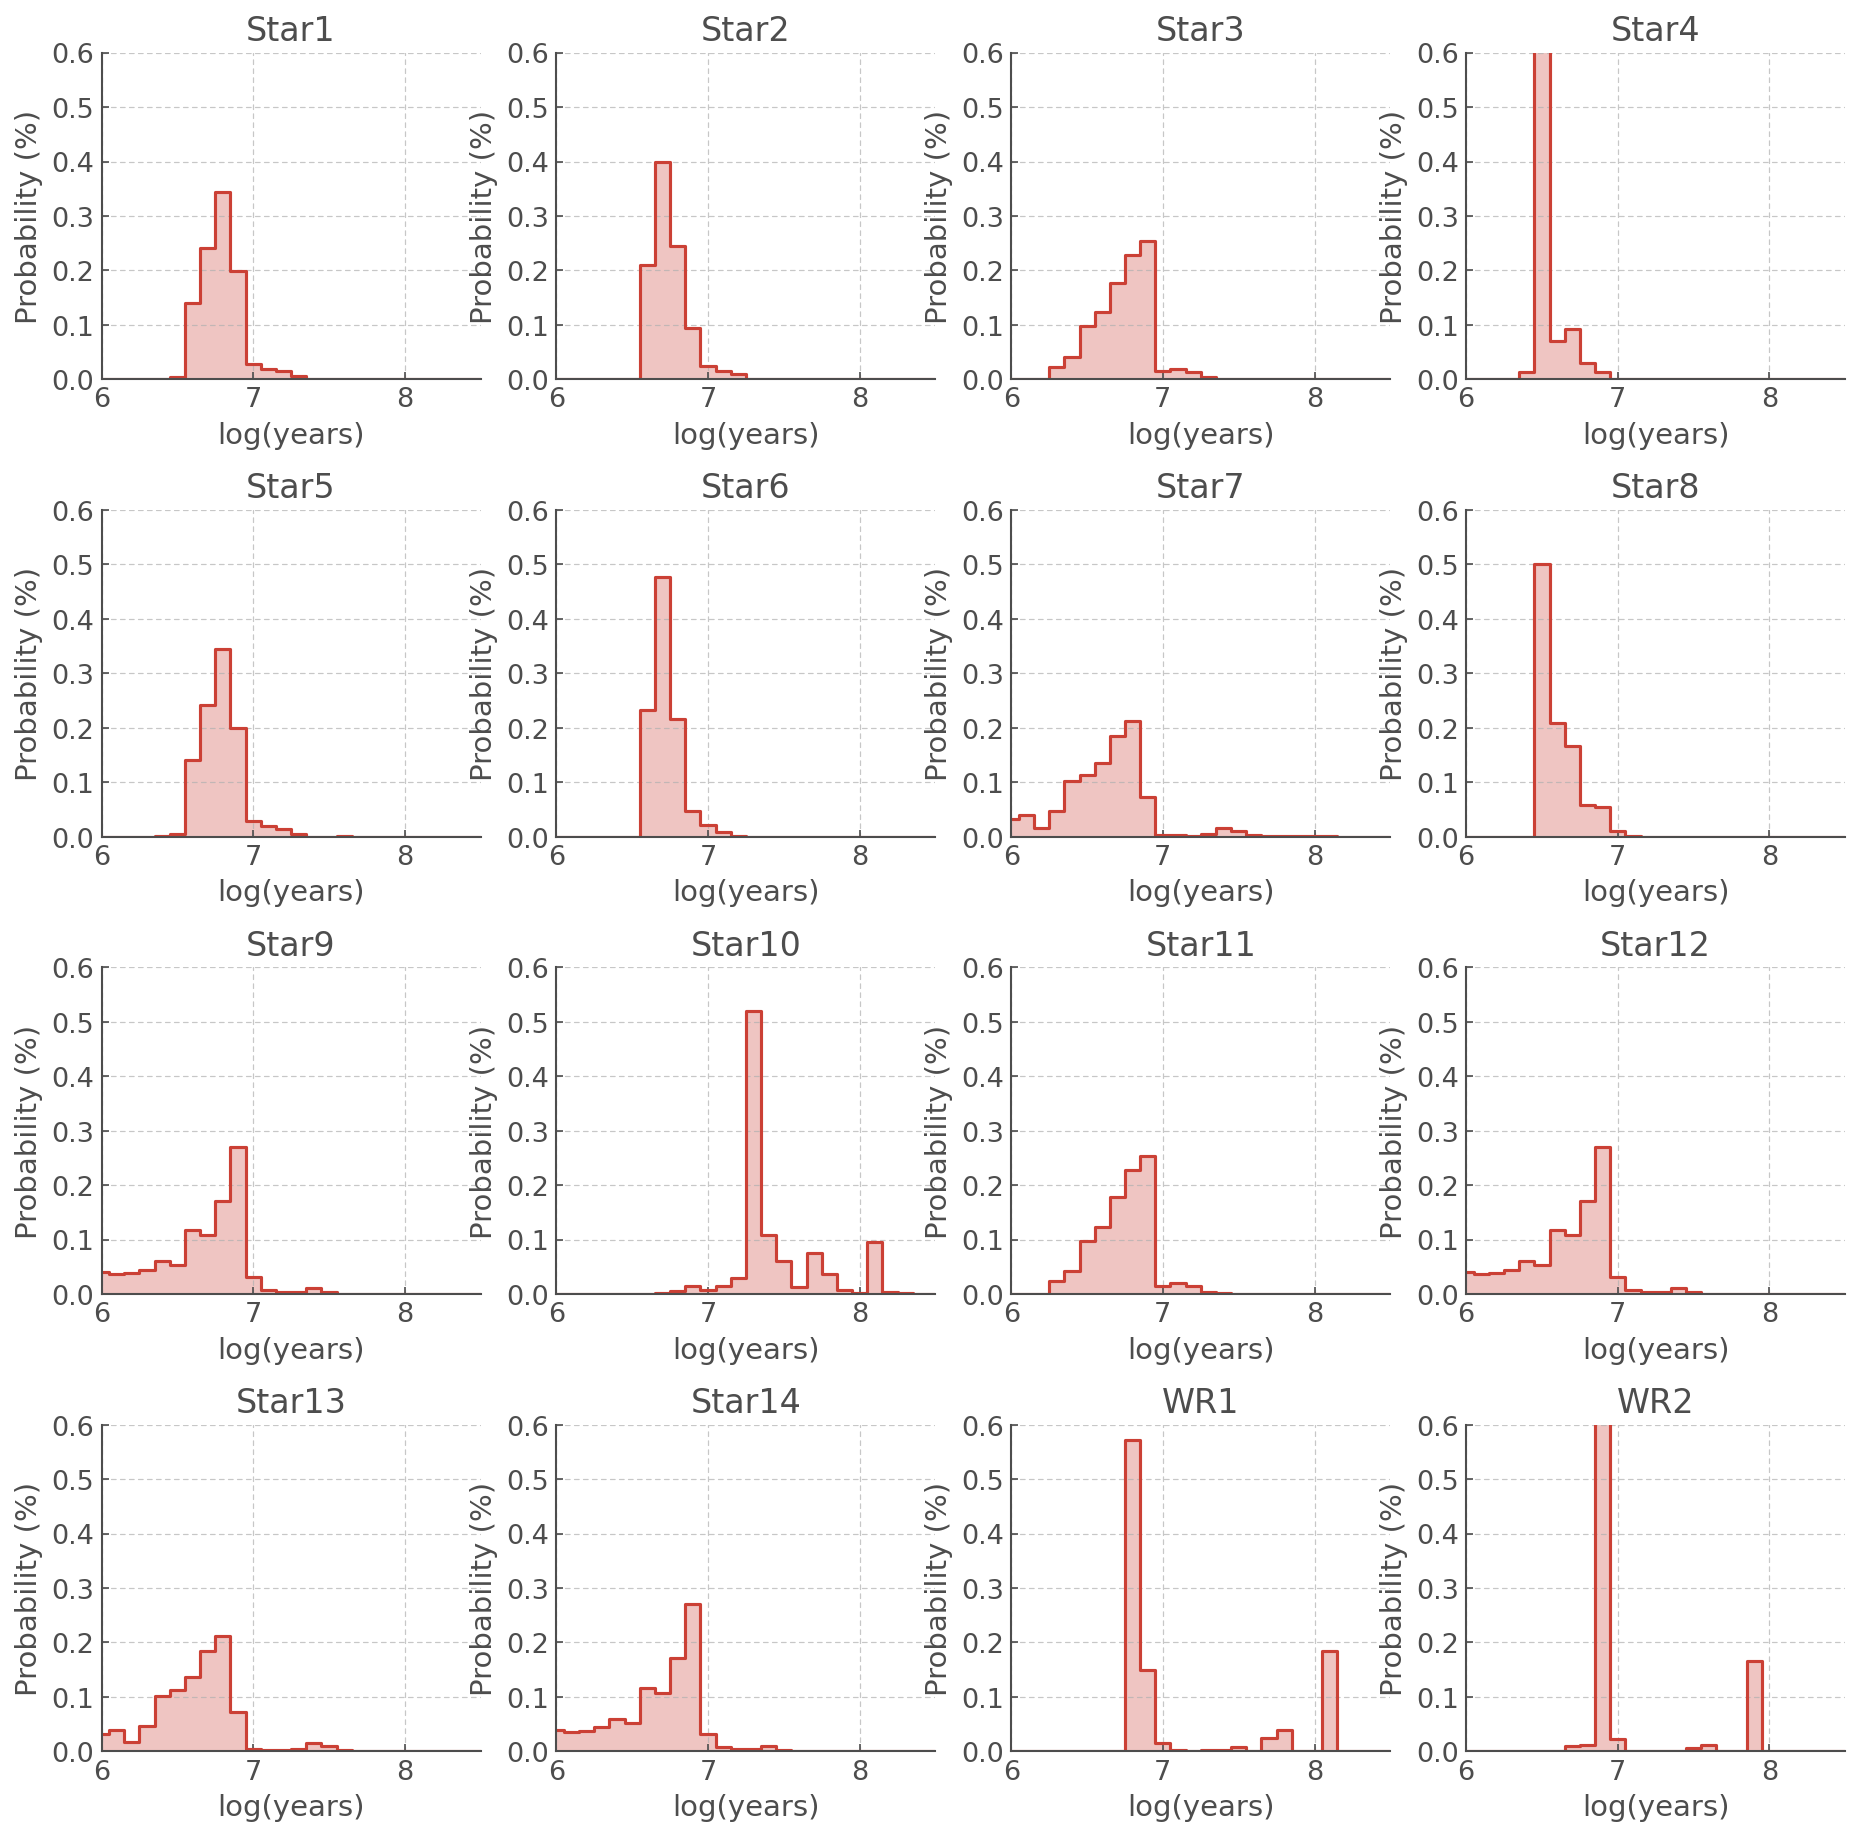

In [7]:
plot_all_pdfs(agewiz008)

# Most Likely Ages

The most likely age for **each source** is summarised by `AgeWizard.most_likely_ages`. This is returned as a numpy array.

In [8]:
agewiz006.most_likely_ages

array([6.9, 6.7, 6.8, 6.5, 6.9, 6.7, 6.8, 6.7, 6.9, 7.3, 6.8, 6.9, 6.8,
       6.9, 6.9, 6.9])

Different metallicities will give different results. In this example we summarise our results into a new DataFrame:

In [9]:
most_likely_ages = pd.DataFrame.from_dict({'name': agewiz006.sources, 
                                           'z006': agewiz006.most_likely_ages, 
                                           'z008': agewiz008.most_likely_ages}) 

# Note that the attribute AgeWizard.sources is the list of names you provided, or if you didn't the ones it created

In [10]:
most_likely_ages

,name,z006,z008
0,Star1,6.9,6.8
1,Star2,6.7,6.7
2,Star3,6.8,6.9
3,Star4,6.5,6.5
4,Star5,6.9,6.8
5,Star6,6.7,6.7
6,Star7,6.8,6.8
7,Star8,6.7,6.5
8,Star9,6.9,6.9
9,Star10,7.3,7.3


### IMPORTANT
The `most_likely_ages` (and `most_likley_age`, see below) tools **do not give you a direct answer** - they are a way to summarise the data and be used in your interpretation but **please do not use these as a black box**.

Looking at the PDFs plotted above and the table of most likely ages, we can see that a few stars stand out:

* Star 4 has a lower (most likely) age than the rest of the sample
* Star 10 has a higher (most likely) age than the rest of the sample
* The WR PDFs show peaks beyond log(age/years) - which souldn't be possible for WR stars.

All of these are discussed an interpreted in details in Stevance et al. (in prep). Star 4 is an example of a star that is probably the result of a merger and rejuvination, Star 10 is more likely to be on the young tail of the distribution and not as old as the most likley age implies, and the WR stars share their HRD locations with helium stars which appear at later times, which populate the later peak. 


# Plotting Aggregate Ages

If you are looking for the age of a whole population then you can ask `AgeWizard` to combine the PDFs it calcualted on initialisation. This is done with the method `AgeWizard.calcualte_sample_pdfs()`. 

It can be called as such and it will multiply all the PDFs, or you can provide a list of columns to ignore in the paramter `not_you`. You can also ask it to return the resulting PDF by setting `return_df` to True. If you don't, it will store the result in `AgeWizard.sample_pdf`.

In [11]:
# Returns None
agewiz006.calculate_sample_pdf()

In [12]:
agewiz006.sample_pdf.head(10)

,pdf
0,0.013998
1,0.010557
2,0.012814
3,0.017775
4,0.021274
5,0.072452
6,0.079372
7,0.189020
8,0.199454
9,0.233262


You can also quickly retrieve the **most likely age of the whole sample** from the PDF you just calculated using `AgeWizard.most_likely_age`.

In [13]:
agewiz006.most_likely_age

array([6.9])

In [14]:
# Or return directly
agewiz008.calculate_sample_pdf(return_df=True).head(10)

,pdf
0,0.011530
1,0.011737
2,0.009253
3,0.017201
4,0.030133
5,0.116927
6,0.117052
7,0.167216
8,0.201176
9,0.187655


In [15]:
agewiz008.most_likely_age

array([6.8])

Down below we create a quick function to plot our aggregate ages for z=0.006 and z=0.008. 

As an example of the 

In [16]:
cluster1_sources = ['Star1', 'Star2', 'Star3', 'Star4', 'WR1']
cluster2_sources = [item for item in agewiz006.sources if item not in cluster1_sources]

In [17]:
def plot_aggregate_age(agewiz, ax):
    
    # Aggregate age PDF for all sources
    cluster12 = agewiz.calculate_sample_pdf(return_df=True).pdf
    
    # Aggregate age PDF for cluster1
    cluster1 = agewiz.calculate_sample_pdf(not_you=cluster2_sources, return_df=True).pdf
    
    # Aggregate age PDF for cluster2
    cluster2 = agewiz.calculate_sample_pdf(not_you=cluster1_sources, return_df=True).pdf


    
    ax.step(hoki.BPASS_TIME_BINS, cluster1, where='mid', alpha=1, lw=2)
    ax.fill_between(hoki.BPASS_TIME_BINS, cluster1, step='mid', alpha=0.1,  label='Cluster1')
    
    ax.step(hoki.BPASS_TIME_BINS, cluster2, where='mid', alpha=1, lw=2)
    ax.fill_between(hoki.BPASS_TIME_BINS,  cluster2, step='mid', alpha=0.3,  label='Cluster2')
    
    ax.step(hoki.BPASS_TIME_BINS, cluster12, where='mid',alpha=0.5, c='k', lw=2)
    ax.fill_between(hoki.BPASS_TIME_BINS,  cluster12, step='mid', alpha=0.2, label='All', color='k')


    ax.set_ylabel('Probability')
    ax.set_xlabel('log(ages)')

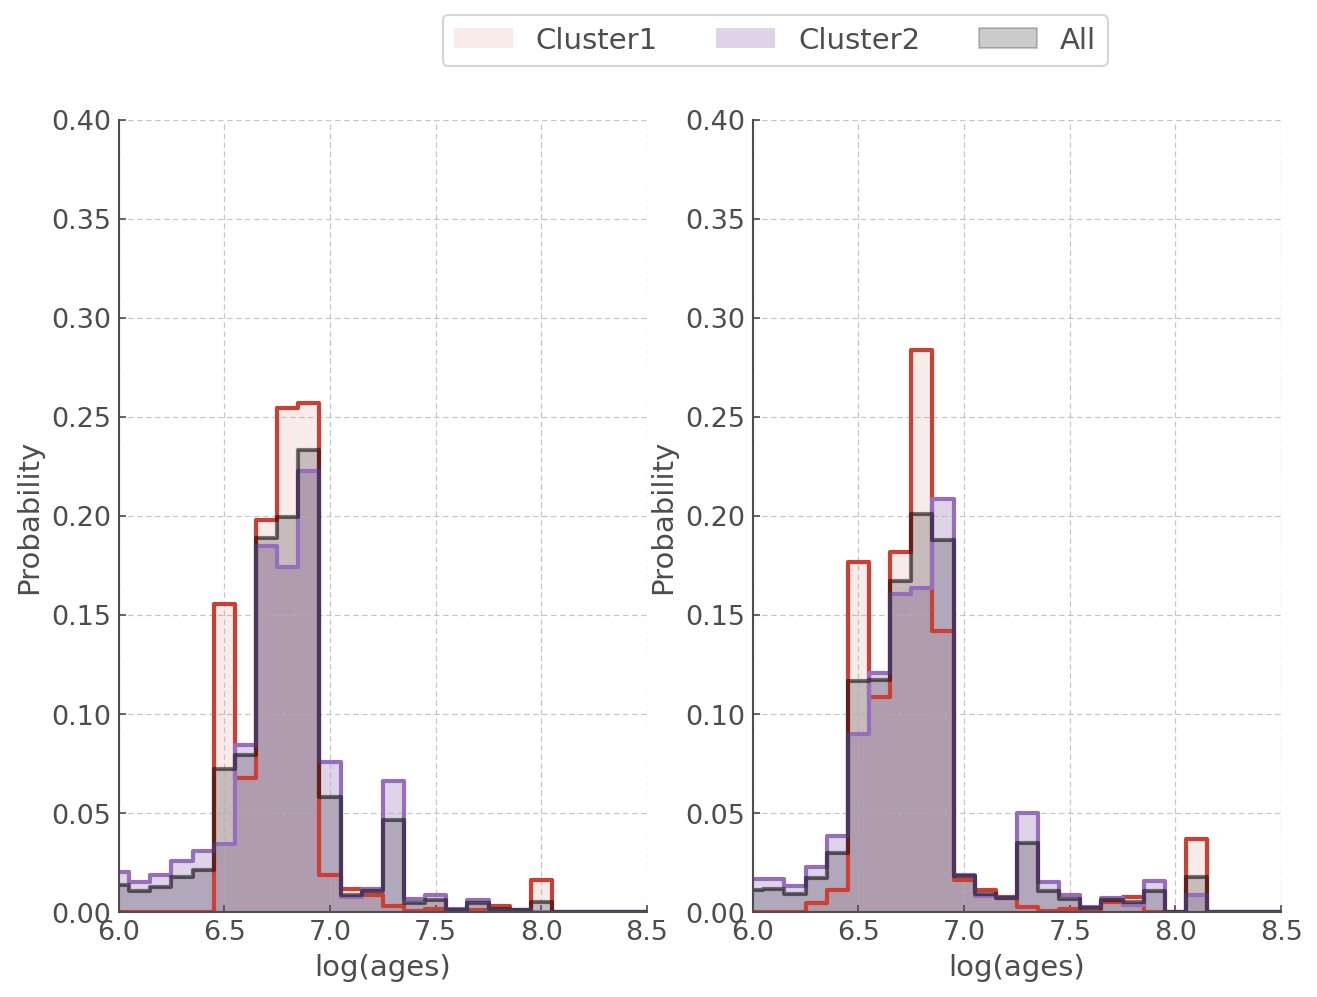

In [18]:
f, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,7))

plot_aggregate_age(agewiz006, ax[0])
plot_aggregate_age(agewiz008, ax[1])

for axis in ax:
    axis.set_ylim([0,0.4])
    axis.set_xlim([6,8.5])
    
# Cool legend
ax[0].legend(fontsize=14, loc='center right', bbox_to_anchor=(1.9, 1.1), ncol=3)

# Probability given an age range

The BPASS time bins are separated by 0.1 dex in log space (log(age/years) = 6.0, 6.1, 6.2, 6.3 etc..) and the PDFs for your individual sources will cover a range of BPASS time bins.

Consequently, giving a single age may not make a lot of sense. Also the PDFs will rarely, if ever, resemble a Gaussian distribution: that means that you can't give an error bar in the "classical" sense. 

Another interesting measure is the probability that the age of your star falls into a chosen age range. 
In this case our aggregate age is most likely to be between 6.7-6.9, so let's investigate how likely it is for each individual star to fall in that range. 

For that we use `AgeWizard.calculate_p_given_age_range()` which returns a Series containing the probabilities corresponding to each source.

In [19]:
agewiz006.calculate_p_given_age_range([6.7, 6.9])

name
Star1     0.857630
Star2     0.932043
Star3     0.779729
Star4     0.127003
Star5     0.857630
Star6     0.948770
Star7     0.500073
Star8     0.666553
Star9     0.446666
Star10    0.023493
Star11    0.779729
Star12    0.446666
Star13    0.500073
Star14    0.446666
WR1       0.850846
WR2       0.784204
dtype: float64

We can collate those in one single DataFrame

In [20]:
p_ages_679 = pd.DataFrame.from_dict({'name': agewiz006.sources, 
                                     'z006': agewiz006.calculate_p_given_age_range([6.7,6.9]), 
                                     'z008': agewiz008.calculate_p_given_age_range([6.7,6.9])}) 

In [21]:
p_ages_679

,name,z006,z008
name,,,
Star1,Star1,0.857630,0.784335
Star2,Star2,0.932043,0.737951
Star3,Star3,0.779729,0.659319
Star4,Star4,0.127003,0.134967
Star5,Star5,0.857630,0.784335
Star6,Star6,0.948770,0.738479
Star7,Star7,0.500073,0.469008
Star8,Star8,0.666553,0.278005
Star9,Star9,0.446666,0.549145


To learn more about how we use and interpret this statistic, you can checkout [Stevance et al 2020](https://ui.adsabs.harvard.edu/#abs/2020MNRAS.498.1347S/abstract)

# Errors on L and T

But what if my luminosity and temperature values have errors? 

AgeWizard in the `hoki.age.wizard` subpackage (in `hoki v1.6`) can take care of that. The legacy version cannot. 

To show you how it runs we're going to use a **made up** example (these are the numbers I use in the unitest).
The **errors have to be given in the following columns `logL_err` and `logT_err`**.

- **GIVE THE 1 SIGMA ERRORS**
- If your errors are asymmetric -- pick the largest value. 


In [22]:
stars_SYM = pd.DataFrame.from_dict({'name': np.array(['118-1', '118-2', '118-3', '118-4']),
                                    'logL': np.array([5.0, 5.1, 4.9, 5.9]),
                                    'logL_err': np.array([0.1, 0.2, 0.1, 0.1]),
                                    'logT': np.array([4.48, 4.45, 4.46, 4.47]),
                                    'logT_err': np.array([0.1, 0.2, 0.1, 0.1]),
                                    })

### How are the errors taken into account?

Basically bootstrapping. Each data point is thought of as a gaussian distribution centered on the value with standard deviation the error your gave (that is why I ask you to give AgeWizard the 1 sigma level). 

Then for each data point is drawn from that distribution and the individual age PDFs are calculated as usual. 
This process is repeated `n_samples` times and the individual pdfs are then combined. 

Finally you can get the age PDF of the whole cluster (or sample) by doinmg the usual `AgeWizard.calculate_sample_pdf()`. 


In [24]:
errwiz = AgeWizard(stars_SYM, model='./data/hrs-bin-imf135_300.z006.dat', nsamples=200)
errwiz.calculate_sample_pdf()

[---INFO---] AgeWizard Starting
[--RUNNING-] Initial Checks
Stack has been reset
[-COMPLETE-] Initial Checks
[---INFO---] ERROR_FLAG=SYM / Strictily symmetric errors detected
None
[---INFO---] Distributions Calculated Successfully
[---INFO---] Distributions Normalised to PDFs Successfully


Text(0.5, 1.0, "And you can plot it as usual\nIt's just broader now :)")

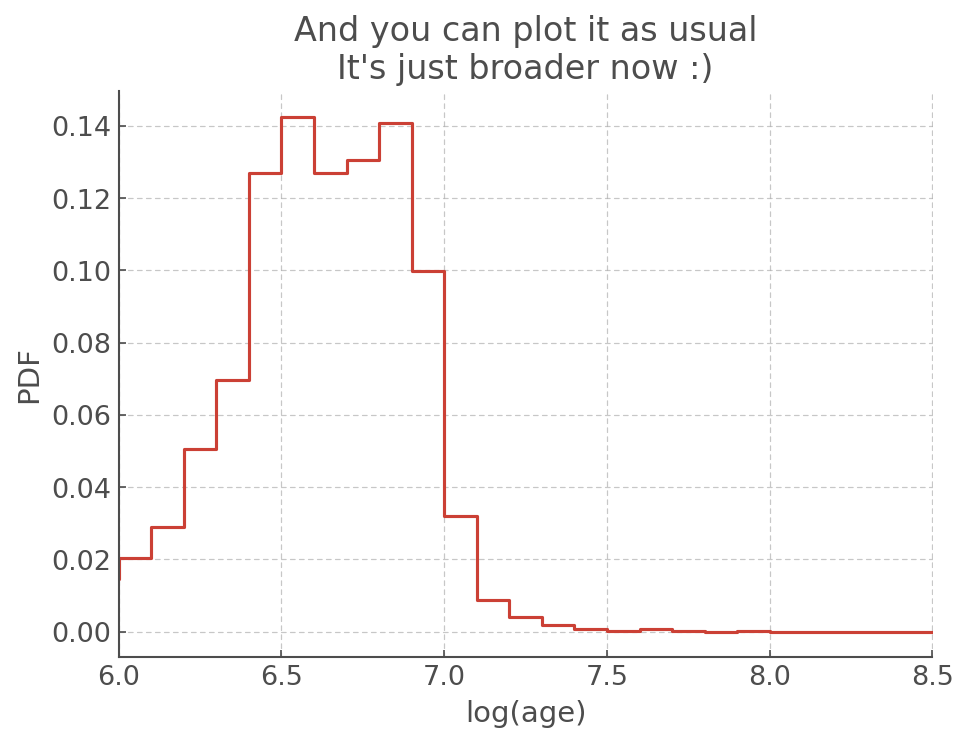

In [32]:
plt.step(errwiz.t, errwiz.sample_pdf.pdf)
plt.xlabel('log(age)')
plt.ylabel('PDF')
plt.xlim([6,8.5])
plt.title("And you can plot it as usual\nIt's just broader now :)")

# Ages from Colour-Magnitude Diagram 

In this section we will see how we can use `AgeWizard` on a Colour-Magnitude Diagram (CMD).
**It is essentially the same as for the HR Diagrams** but you will be giving `AgeWizard` a `hoki.CMD` object instead of a `hoki.HRDiagram` object. 

This example is taken from [Brennan et al. 2021b](https://arxiv.org/abs/2102.09576) where we look at the neighbourhood of AT2016jbu to try and infer the age. 

### Loading data

To help you we've attached a couple of pre-made CMDs. You can make your own following the `CMD.ipynb` tutorial, or if you don't want to download 50GB of stellar models you can send me an email and for the low price of adding me to your author list I will make them for you. 

In addition to the models we need to download the data and turn observed magnitudes into absolute magnitudes by removing the distance modulus and the extinction. 

In [58]:
# The BPASS synthetic CMDs
f435cmd = unpickle(path='./data/F435_F555.pckl')
f555cmd = unpickle(path='./data/F555_F814.pckl')


# The observed data
cmd_obs = pd.read_csv('./data/phot_150pc.dat')
cmd_obs.replace([99.999, 9.999], np.nan, inplace=True) # cleaning up bad values

# Absolute magnitudes
# - 31.6 is the distance modulus to NGC242 and the other value is extinction see Brennan et al. 2021
F435 = cmd_obs.F435W - 31.6 - 0.732
F555 = cmd_obs.F555W - 31.6 - 0.579
F814 = cmd_obs.F814W - 31.6 - 0.309

# we add teh absolute magnitudes to the dataframe, it'll be useful later
cmd_obs['abs_F435'] = F435
cmd_obs['abs_F555'] = F555
cmd_obs['abs_F814'] = F814

Text(0.5, 0.98, 'Stars 150pc around AT 2016jbu')

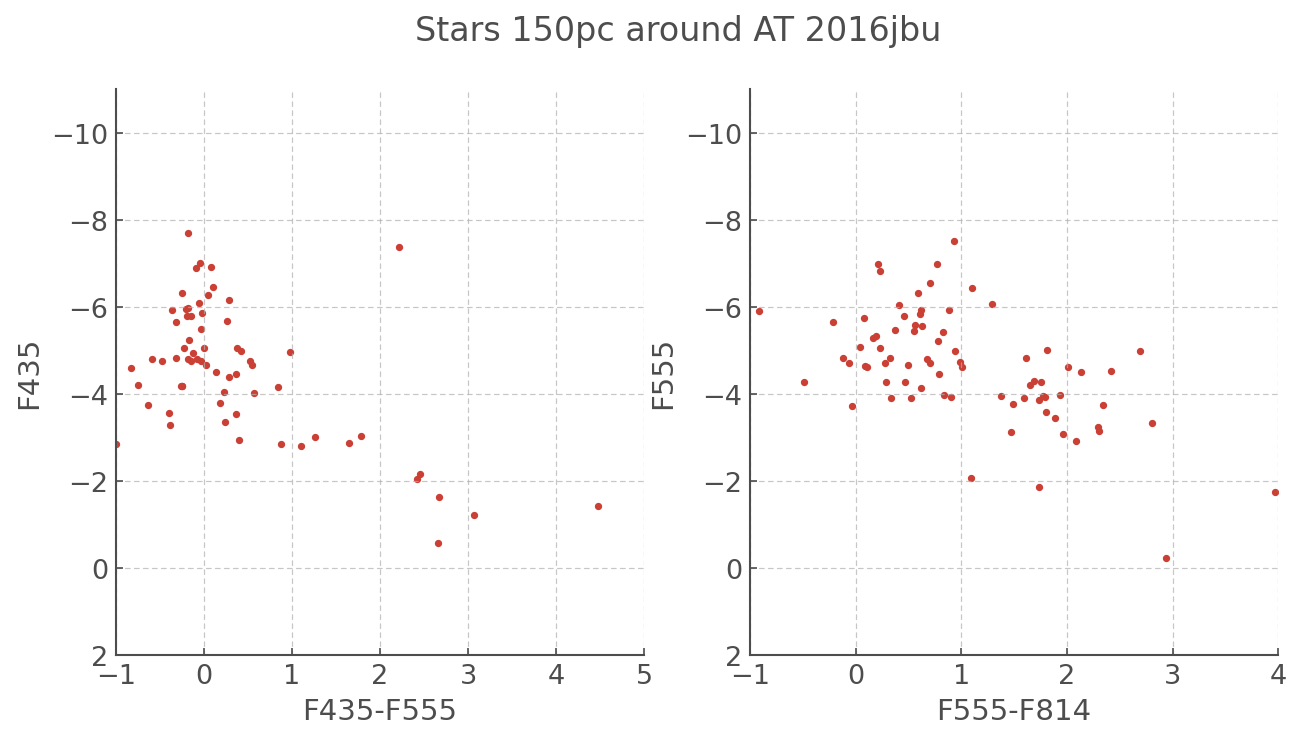

In [57]:
fig, ax = plt.subplots(ncols = 2, figsize=(10,5))

ax[0].scatter(F435-F555, F435)
ax[0].set_xlim([-1,5.0])
ax[0].set_ylim([2,-11])
ax[0].set_xlabel('F435-F555')
ax[0].set_ylabel('F435')

ax[1].scatter(F555-F814, F555)
ax[1].set_xlim([-1,4])
ax[1].set_ylim([2,-11])
ax[1].set_xlabel('F555-F814')
ax[1].set_ylabel('F555')

plt.suptitle('Stars 150pc around AT 2016jbu', fontsize=16)

# Putting constraints on the age of a population using AgeWizard

The CMDs are very scattered and it might seem like there isn't much we can do, but trust the process...
Let's take a look at them with some BPASS CMDs plotted underneath

/home/fste075/hoki/hoki/cmd.py:348: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys"))
  colMap.set_under(color='white')


(2.0, -11.0)

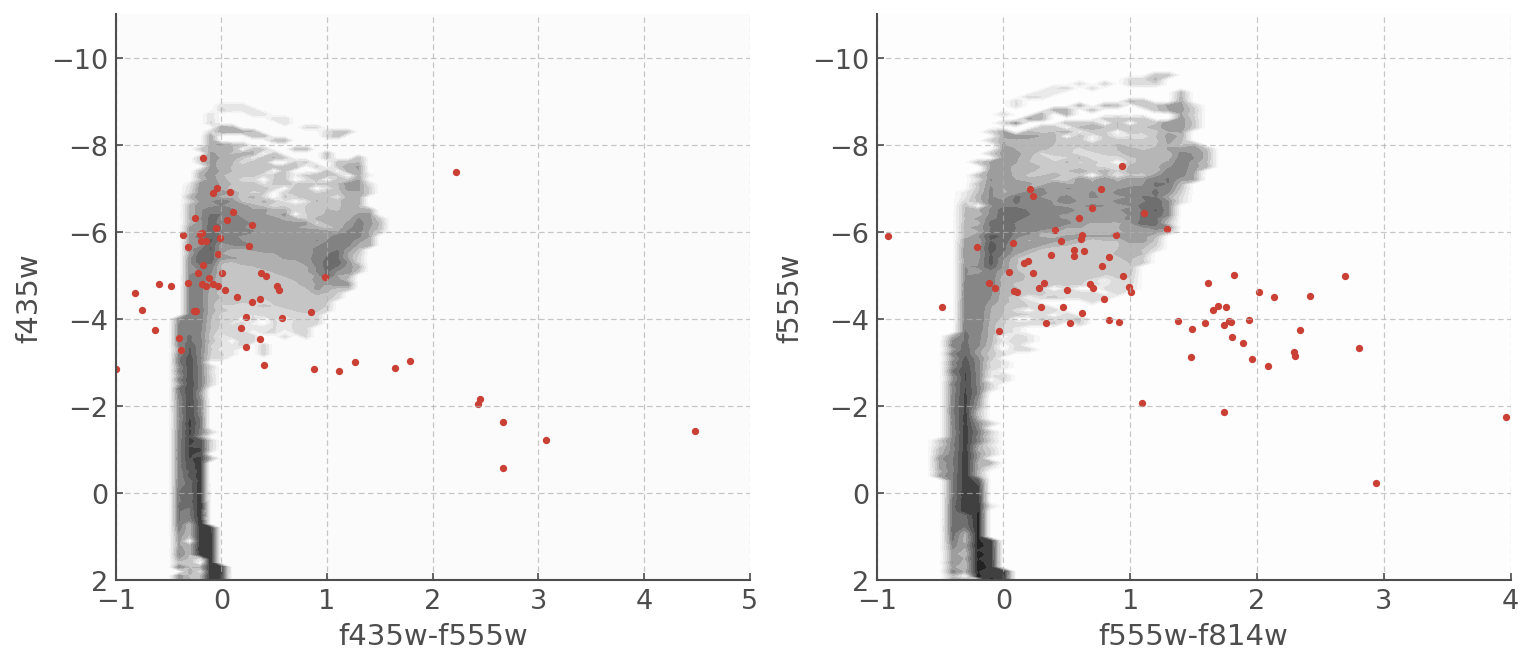

In [27]:
f, ax = plt.subplots(ncols=2,figsize=(12,5))

myplot = f435cmd.plot(log_age=7.5, loc=ax[0]) # Here you can chose the time bin you want to plot.
myplot.scatter(F435-F555, F435)
myplot.set_xlim([-1,5.0])
myplot.set_ylim([2,-11])

myplot = f555cmd.plot(log_age=7.5, loc=ax[1]) # Here you can chose the time bin you want to plot.
myplot.scatter(F555-F814, F555)
myplot.set_xlim([-1,4])
myplot.set_ylim([2,-11])

The scatter will make it hard (impossible) to get a neat and precise age estimate, but we can put constraints on the age and exclude age ranges that really don't fit the data. Creating the age pdf is very useful for that. 

The first thing we will do is cut-off some of the more dificult data - we see that below an absolute mag of -4 the data slides unexpectedly to the right. That horizontal displacement is not from stellar evolution so we're going to **apply a luminosity cut-off and only pick the stars brighter than -4.**

### Luminosity cut-off

In [59]:
## we crop our dataframe based on the absolute magnitude and the cut-off we chose
cmd_obs_crop=cmd_obs[(cmd_obs.abs_F435<-4) & (cmd_obs.abs_F555<-4)]

# we can also create columns for the colours.
cmd_obs_crop['F555-F814'] = cmd_obs_crop.abs_F555-cmd_obs_crop.abs_F814
cmd_obs_crop['F435-F555'] = cmd_obs_crop.abs_F435-cmd_obs_crop.abs_F555

<ipython-input-59-93413fe7f498>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmd_obs_crop['F555-F814'] = cmd_obs_crop.abs_F555-cmd_obs_crop.abs_F814
<ipython-input-59-93413fe7f498>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmd_obs_crop['F435-F555'] = cmd_obs_crop.abs_F435-cmd_obs_crop.abs_F555


### AgeWizard

Now we can give all that to `AgeWizard`! We need to create **two instances** one for each CMD. We can then combine their results later. 

**NOTE: `AgeWizard` expects the observational data to have at least two columns with names `mag` and `col`**.

In [60]:
##### CMD1 - F555 F814 
# we drop the NaN values we used to mark the bad measurements 
obs_df1=cmd_obs_crop[['abs_F555','F555-F814' ]].dropna()

# AgeWizard needs specific column names
obs_df1.columns=['mag','col']
agewiz1 = AgeWizard(obs_df1, model=f555cmd)

# Calculate the Age PDF of the whole sample from the individual age pdfs
agewiz1.calculate_sample_pdf()

[---INFO---] AgeWizard Starting
[--RUNNING-] Initial Checks
[-COMPLETE-] Initial Checks
[---INFO---] ERROR_FLAG=None / No errors detected
[---INFO---] Distributions Calculated Successfully
[---INFO---] Distributions Normalised to PDFs Successfully


/home/fste075/hoki/hoki/age/wizard.py:44: HokiFormatWarning: We expect the name of sources to be given in the 'name' column. If I can't find names I'll make my own ;)
  warnings.warn("We expect the name of sources to be given in the 'name' column. "
/home/fste075/hoki/hoki/age/utils.py:418: HokiUserWarning: No source names given so I'll make my own
  warnings.warn("No source names given so I'll make my own", HokiUserWarning)


In [61]:
##### CMD2 - F435 F555
obs_df2=cmd_obs_crop[['abs_F435','F435-F555' ]].dropna()
obs_df2.columns=['mag','col']
agewiz2 = AgeWizard(obs_df2, model=f435cmd)

# Calculate the Age PDF of the whole sample from the individual age pdfs
agewiz2.calculate_sample_pdf()

[---INFO---] AgeWizard Starting
[--RUNNING-] Initial Checks
[-COMPLETE-] Initial Checks
[---INFO---] ERROR_FLAG=None / No errors detected
[---INFO---] Distributions Calculated Successfully
[---INFO---] Distributions Normalised to PDFs Successfully


/home/fste075/hoki/hoki/age/wizard.py:44: HokiFormatWarning: We expect the name of sources to be given in the 'name' column. If I can't find names I'll make my own ;)
  warnings.warn("We expect the name of sources to be given in the 'name' column. "
/home/fste075/hoki/hoki/age/utils.py:418: HokiUserWarning: No source names given so I'll make my own
  warnings.warn("No source names given so I'll make my own", HokiUserWarning)
/home/fste075/hoki/hoki/age/utils.py:30: RuntimeWarning: invalid value encountered in true_divide
  return distribution / area


Text(0.5, 0, 'log(age)')

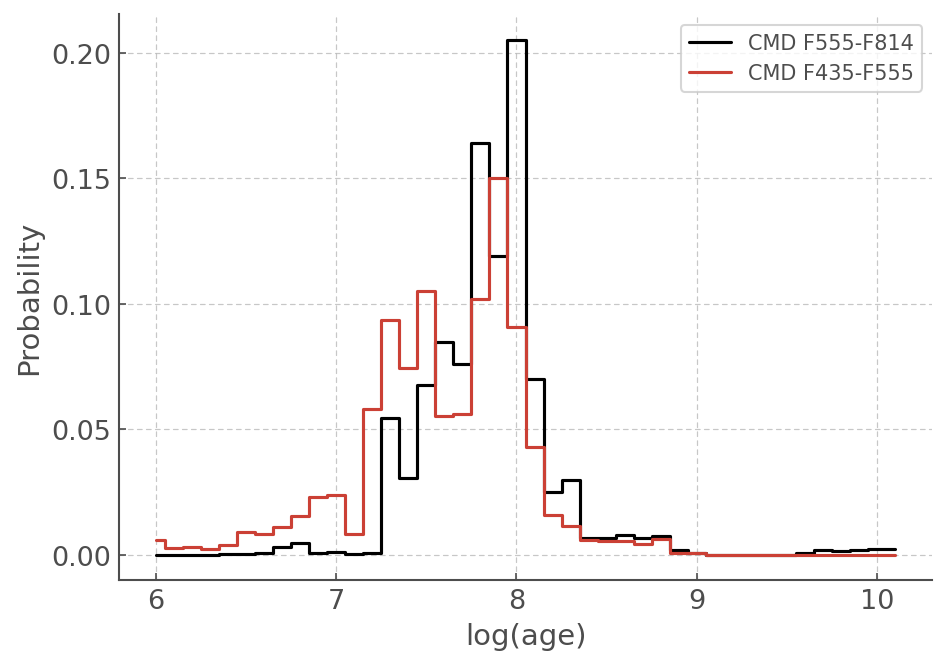

In [66]:
plt.step(agewiz1.t[:42], agewiz1.sample_pdf[:42], where='mid', c='k', label='CMD F555-F814')
plt.step(agewiz2.t[:42], agewiz2.sample_pdf[:42], where='mid',  label='CMD F435-F555')
plt.legend()

plt.ylabel('Probability')
plt.xlabel('log(age)')

### Combine the PDFs from the two CMDs

In [67]:
# creates a new data frame with the final, combined, age pdf
combined_pdf = 0.5*(agewiz1.sample_pdf+agewiz2.sample_pdf)
# adds the time axis (x axis) to the index instead of having a range from 0 to 51 - eases plotting. 
combined_pdf.index = agewiz2.t

Text(0.5, 0, 'log(age)')

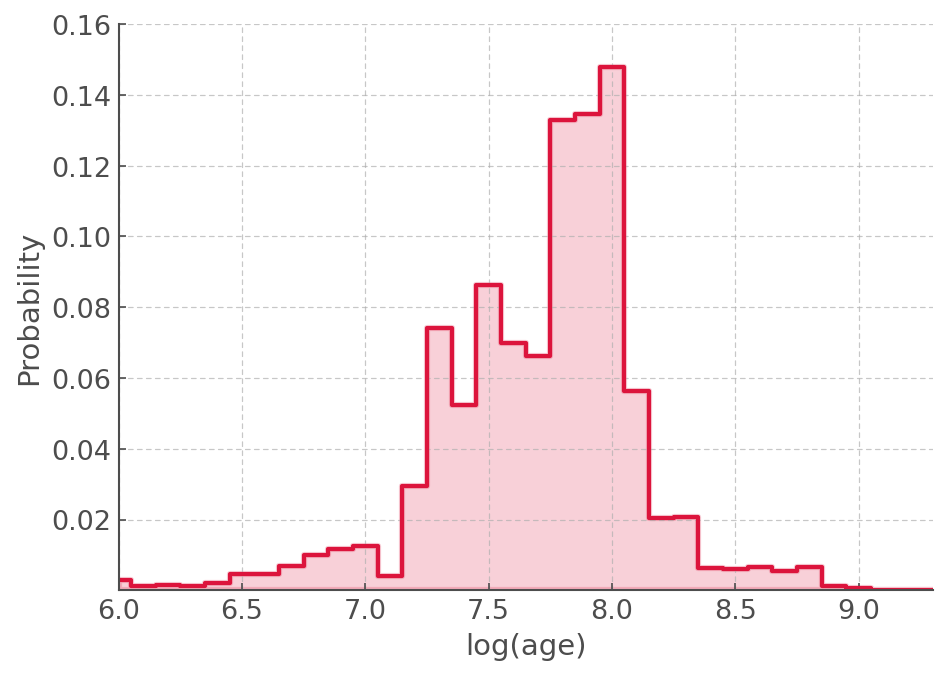

In [68]:
plt.step(combined_pdf.index , combined_pdf, where='mid', lw=2,color='crimson')
plt.fill_between(combined_pdf.index.values, combined_pdf.pdf, step='mid', color='crimson',lw=3, 
                 alpha=0.2, zorder=0.2)
plt.xlim([6,9.3])
plt.ylim([0.000001,0.16])
plt.ylabel('Probability')
plt.xlabel('log(age)')
#plt.savefig('pdf_AgeWizard')

### Age constraint

The PDF is very broad because the data is very scattered **but** the young ages are in a very low probably region. 

We can quantify this by adding up the first 10 bins (10 Million years) and see how much probability is in it:

In [73]:
proba_less_than_10Myr = combined_pdf.iloc[:10].sum().values[0]*100

In [75]:
f"The probability that this population is less than 10 Myrs if {round(proba_less_than_10Myr,2)} percent"

'The probability that this population is less than 10 Myrs if 4.67 percent'